## Paroscientific Lab test (Full Scale Pressurization 2,000psi on the SOS modules, 40Hz data)
### Test123 test1,2 5min pressurization 10min release, test3 10min pressurization 1 hour release 
### Test123 is recomended not to use because testsetting was not consistent with other tests regarding oil filling
### Test456 5min pressurization 10min release (after re-oil-filled)
### Test7 2days pressurization 1hour release
### Test8 3days pressurization 1hour release
### Test8 contains anomalous cyclic variation

In [376]:
import os, glob, re
from pathlib import Path
from datetime import timedelta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt

In [400]:
# ============================================================
# Settings
# ============================================================
ROOT_DIR   = Path("./data/")   # ★ Root folder
TEST_DIRS  = ["test123","test456","test7","test8"]
RESULT_DIR = ROOT_DIR / "result"
RESULT_DIR.mkdir(exist_ok=True)

SENSOR_IDS = ["01","02"]     # Use ["01"] for GSSM01 only, or ["01","02"] for both
PSI_TO_HPA = 68.9476         # psi → hPa

# Temperature compensation coefficients (per module)
#   corr_S1_psi = (Sensor5 - baro_P) + tc1 * Sensor6
#   corr_S2_psi = (Sensor7 - baro_P) + tc2 * Sensor8
COEFFS = {
    "01": (-0.00267, -0.00153),
    "02": (0.00103,  -0.00732),  # Update as needed
}

# Segment extraction conditions
THRESH_S1   = 20      # Sensor5 < THRESH_S1 → test condition
THRESH_S2   = 20      # Sensor7 < THRESH_S2 → test condition
MIN_SEG_SEC = 500     # [s] ignore True segments shorter than this duration
WIN_BEFORE  = 120      # [min] window start: t0 - WIN_BEFORE
WIN_AFTER   = 120      # [min] window end:   t0 + WIN_AFTER

# Plot settings (colors & labels per test folder)
PLOT_COLORS = {
    "test8":   {"pressure": "blue",  "temp": "dodgerblue"},
    "test7":   {"pressure": "red",   "temp": "tomato"},
    "test456": {"pressure": "green", "temp": "limegreen"},
    "test123": {"pressure": "black", "temp": "black"},
}
PLOT_LABELS = {
    "test8":   "Test8",
    "test7":   "Test7",
    "test456": "Test456",
    "test123": "Test123",
}


In [402]:
# ============================================================
# Utility functions
# ============================================================
def butter_lowpass_filter(data, cutoff, fs, order=4):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype="low", analog=False)
    return filtfilt(b, a, data)

def zero_mean_by_window(series, elapsed_s, t0=100, t1=500):
    """Subtract mean over elapsed_s in [t0, t1]."""
    base = series.loc[(elapsed_s >= t0) & (elapsed_s <= t1)].mean()
    return series - base


In [404]:
# ============================================================
# 1. Combine BAROM from .txt files
# ============================================================
def combine_barom_for_sensor(test_dir: Path, sid: str) -> pd.DataFrame:
    pattern = test_dir / f"GSSM{sid}_BAROM_*_UTC.txt"
    files = sorted(glob.glob(str(pattern)))
    dfs = []

    if not files:
        print(f"[WARN] {test_dir.name} GSSM{sid}: No BAROM files for '{pattern}'")
        return pd.DataFrame()

    for fp in files:
        if os.path.getsize(fp) == 0:
            print(f"[INFO] Skipped empty BAROM file: {fp}")
            continue

        try:
            with open(fp, "r") as f:
                rows = [line.strip().split(",") for line in f if line.strip()]
            clean_rows = [r for r in rows if len(r) == 3]
            if not clean_rows:
                print(f"[INFO] No valid 3-column BAROM rows in: {fp}")
                continue

            df = pd.DataFrame(clean_rows, columns=["Timestamp", "Sensor1", "Sensor2"])
            df["Timestamp"] = pd.to_datetime(
                df["Timestamp"], format="%m-%d-%Y %H:%M:%S.%f", errors="coerce"
            )
            df["Sensor1"] = pd.to_numeric(df["Sensor1"], errors="coerce")
            df["Sensor2"] = pd.to_numeric(df["Sensor2"], errors="coerce")

            df = df.dropna(subset=["Timestamp", "Sensor1", "Sensor2"])
            df = df.drop_duplicates(subset="Timestamp", keep="first")
            dfs.append(df)

        except Exception as e:
            print(f"[WARN] BAROM: Could not process {fp}: {e}")

    if not dfs:
        print(f"[WARN] {test_dir.name} GSSM{sid}: No valid BAROM rows.")
        return pd.DataFrame()

    combined = (
        pd.concat(dfs, ignore_index=True)
          .sort_values("Timestamp")
          .reset_index(drop=True)
    )
    return combined


# ============================================================
# 2. Combine PRESS (ACCEL_PRESS) from .txt files
# ============================================================
def combine_press_for_sensor(test_dir: Path, sid: str) -> pd.DataFrame:
    pattern = test_dir / f"GSSM{sid}_ACCEL_PRESS_*_UTC.txt"
    files = sorted(glob.glob(str(pattern)))
    dfs = []

    if not files:
        print(f"[WARN] {test_dir.name} GSSM{sid}: No ACCEL_PRESS files for '{pattern}'")
        return pd.DataFrame()

    for fp in files:
        if os.path.getsize(fp) == 0:
            print(f"[INFO] Skipped empty PRESS file: {fp}")
            continue

        try:
            with open(fp, "r") as f:
                rows = [line.strip().split(",") for line in f if line.strip()]
            clean_rows = [r for r in rows if len(r) == 9]
            if not clean_rows:
                print(f"[INFO] No valid 9-column PRESS rows in: {fp}")
                continue

            df = pd.DataFrame(
                clean_rows,
                columns=[
                    "Timestamp",
                    "Sensor1", "Sensor2", "Sensor3",
                    "Sensor4", "Sensor5", "Sensor6", "Sensor7", "Sensor8",
                ],
            )

            df["Timestamp"] = pd.to_datetime(
                df["Timestamp"], format="%m-%d-%Y %H:%M:%S.%f", errors="coerce"
            )
            for col in [f"Sensor{i}" for i in range(1, 9)]:
                df[col] = pd.to_numeric(df[col], errors="coerce")

            df = df.dropna(subset=["Timestamp"] + [f"Sensor{i}" for i in range(1, 9)])
            df = df.drop_duplicates(subset="Timestamp", keep="first")
            dfs.append(df)

        except Exception as e:
            print(f"[WARN] PRESS: Could not process {fp}: {e}")

    if not dfs:
        print(f"[WARN] {test_dir.name} GSSM{sid}: No valid PRESS rows.")
        return pd.DataFrame()

    combined = (
        pd.concat(dfs, ignore_index=True)
          .sort_values("Timestamp")
          .reset_index(drop=True)
    )
    return combined


In [406]:
# ============================================================
# 3. Merge PRESS and BAROM
# ============================================================
def merge_press_and_barom(press_df: pd.DataFrame,
                          barom_df: pd.DataFrame) -> pd.DataFrame:
    if press_df.empty or barom_df.empty:
        return pd.DataFrame()

    # PRESS: sort by time and rename accel channels to acc1–3
    press_df = (
        press_df.sort_values("Timestamp")
                .reset_index(drop=True)
    )
    press_df = press_df.rename(
        columns={"Sensor1": "acc1", "Sensor2": "acc2", "Sensor3": "acc3"}
    )

    # BAROM: set index to Timestamp and interpolate at PRESS timestamps
    barom_idx = (
        barom_df.sort_values("Timestamp")
                .set_index("Timestamp")
    )
    barom_interp = (
        barom_idx
        .reindex(press_df["Timestamp"])
        .interpolate(method="time")
        .reset_index()
        .rename(columns={"index": "Timestamp"})
    )
    barom_interp = barom_interp.rename(
        columns={"Sensor1": "baro_P", "Sensor2": "baro_T"}
    )

    merged_df = press_df.merge(
        barom_interp[["Timestamp", "baro_P", "baro_T"]],
        on="Timestamp",
        how="left",
    )
    return merged_df


In [408]:
# ============================================================
# 4. Extract calibration intervals by threshold and save as CSV
# ============================================================
def extract_intervals_for_test(merged_df: pd.DataFrame,
                               sid: str,
                               test_name: str) -> Path | None:
    if merged_df.empty:
        return None

    merged_df = merged_df.copy().set_index("Timestamp")

    # Threshold mask (low-pressure regions)
    mask = (merged_df["Sensor5"] < THRESH_S1) & (merged_df["Sensor7"] < THRESH_S2)

    # Group continuous True/False segments
    mask_df = mask.to_frame(name="mask")
    mask_df["grp"] = (mask_df["mask"] != mask_df["mask"].shift()).cumsum()

    segments = []
    for grp_id, grp in mask_df.groupby("grp"):
        if not grp["mask"].iat[0]:
            continue
        t_start = grp.index[0]
        t_end   = grp.index[-1]
        duration = (t_end - t_start).total_seconds()
        if duration < MIN_SEG_SEC:
            continue
        segments.append((t_start, t_end))

    print(f"{test_name} GSSM{sid}: {len(segments)} segments detected")

    all_tests = []
    test_id = 1

    for seg_start, seg_end in segments:
        seg = merged_df.loc[seg_start:seg_end]
        if seg.empty:
            continue

        # t0 = time of minimum Sensor5 in the segment
        t0 = seg["Sensor5"].idxmin()

        # Window: t0 ± configured minutes
        t_start = t0 - timedelta(minutes=WIN_BEFORE)
        t_end   = t0 + timedelta(minutes=WIN_AFTER)
        window = merged_df.loc[t_start:t_end]
        if window.empty:
            continue

        elapsed_s = (window.index - t0).total_seconds()

        df_out = pd.DataFrame(
            {
                "elapsed_s": elapsed_s,
                "acc1":   window["acc1"],
                "acc2":   window["acc2"],
                "acc3":   window["acc3"],
                "Sensor5": window["Sensor5"],   # S1 pressure (psi)
                "Sensor7": window["Sensor7"],   # S2 pressure (psi)
                "Sensor6": window["Sensor6"],   # S1 temperature
                "Sensor8": window["Sensor8"],   # S2 temperature
                "baro_P":  window["baro_P"],    # barometer pressure (psi)
                "baro_T":  window["baro_T"],    # barometer temperature
                "test_id": test_id,
            },
            index=window.index,
        )
        all_tests.append(df_out)
        test_id += 1

    if not all_tests:
        print(f"[WARN] {test_name} GSSM{sid}: no intervals")
        return None

    result = (
        pd.concat(all_tests)
          .reset_index()
          .rename(columns={"index": "Timestamp"})
    )

    out_path = RESULT_DIR / f"gssm{sid}_calibration_intervals_{test_name}.csv"
    result.to_csv(out_path, index=False)
    print(
        f"[INFO] saved {out_path.name}: "
        f"{result['test_id'].nunique()} intervals, {len(result)} rows"
    )

    return out_path


# ============================================================
# 5. For all tests: load → merge → extract intervals
# ============================================================
interval_files = {sid: [] for sid in SENSOR_IDS}

for test_name in TEST_DIRS:
    test_dir = ROOT_DIR / test_name
    if not test_dir.exists():
        print(f"[WARN] test folder not found: {test_dir}")
        continue

    print(f"\n===== PROCESS {test_name} =====")
    for sid in SENSOR_IDS:
        barom_df = combine_barom_for_sensor(test_dir, sid)
        press_df = combine_press_for_sensor(test_dir, sid)

        if barom_df.empty or press_df.empty:
            print(f"[WARN] {test_name} GSSM{sid}: skip (BAROM or PRESS empty)")
            continue

        merged_df = merge_press_and_barom(press_df, barom_df)
        if merged_df.empty:
            print(f"[WARN] {test_name} GSSM{sid}: merged_df empty")
            continue

        out_path = extract_intervals_for_test(merged_df, sid, test_name)
        if out_path is not None:
            interval_files[sid].append(out_path)



===== PROCESS test123 =====
test123 GSSM01: 3 segments detected
[INFO] saved gssm01_calibration_intervals_test123.csv: 3 intervals, 813063 rows
test123 GSSM02: 3 segments detected
[INFO] saved gssm02_calibration_intervals_test123.csv: 3 intervals, 811392 rows

===== PROCESS test456 =====
test456 GSSM01: 3 segments detected
[INFO] saved gssm01_calibration_intervals_test456.csv: 3 intervals, 558273 rows
test456 GSSM02: 3 segments detected
[INFO] saved gssm02_calibration_intervals_test456.csv: 3 intervals, 556833 rows

===== PROCESS test7 =====
test7 GSSM01: 1 segments detected
[INFO] saved gssm01_calibration_intervals_test7.csv: 1 intervals, 193925 rows
test7 GSSM02: 1 segments detected
[INFO] saved gssm02_calibration_intervals_test7.csv: 1 intervals, 193811 rows

===== PROCESS test8 =====
test8 GSSM01: 1 segments detected
[INFO] saved gssm01_calibration_intervals_test8.csv: 1 intervals, 193988 rows
test8 GSSM02: 1 segments detected
[INFO] saved gssm02_calibration_intervals_test8.csv: 1

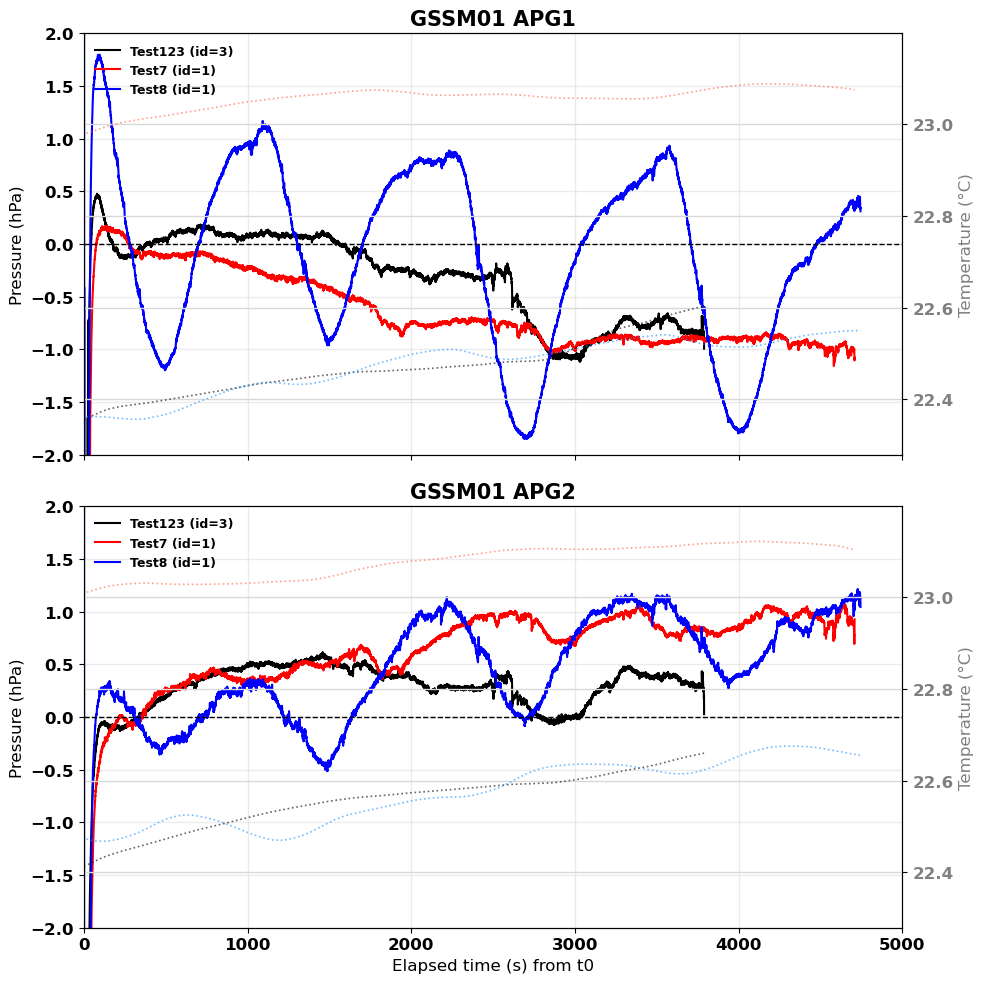

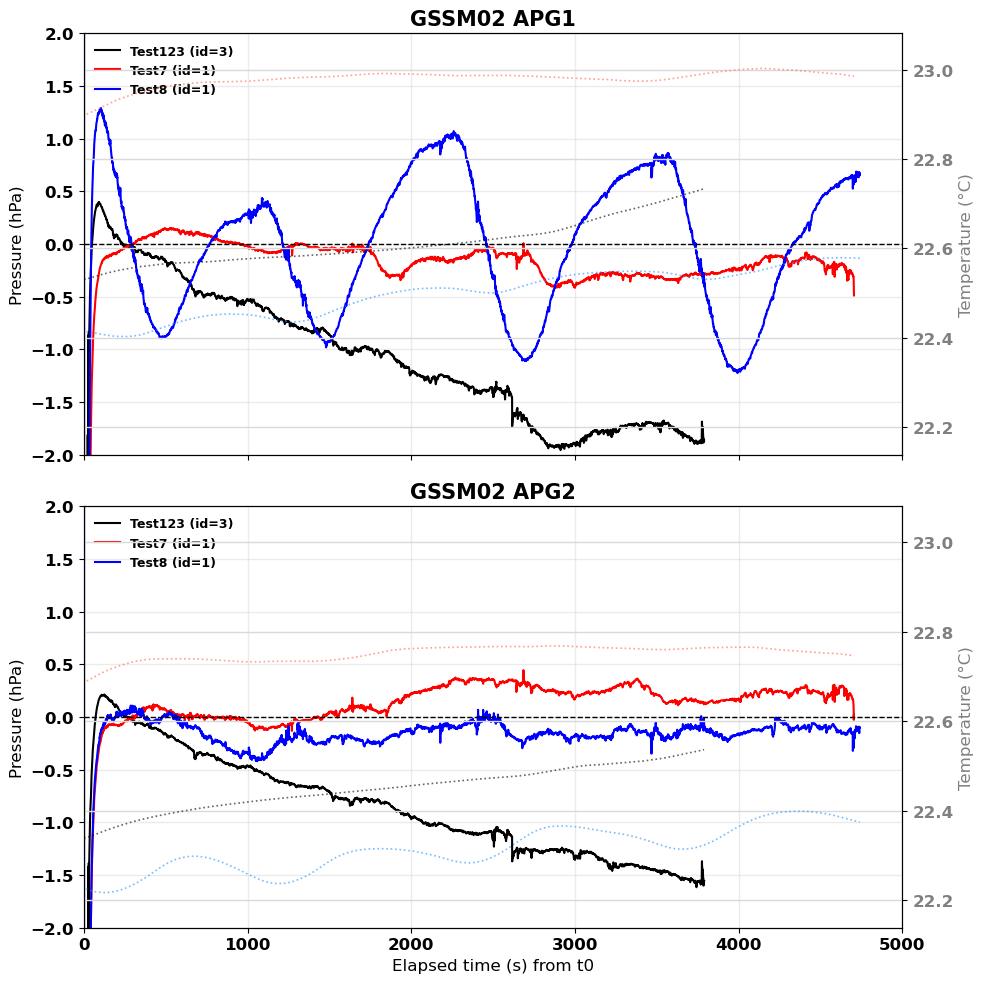

In [418]:
# Which tests to plot (matches test names in filenames: test123 / test7 / test8)
TARGET_TEST_NAMES = {"test123", "test7", "test8"}

# Which test_id to plot for each test (None → use all ids)
ID_FILTER = {
     "test123": {3},
    # "test7":   {1},
    # "test8":   {1},
}

# Base labels for each test name
PLOT_LABELS = {
    "test123": "Test123",
    "test7":   "Test7",
    "test8":   "Test8",
}

# Axis labels
AX_LABELS = {
    "y_pressure": "Pressure (hPa)",
    "y_temp":     "Temperature (°C)",
    "x_elapsed":  "Elapsed time (s) from t0",
}

# Legend config
LEGEND_CFG = {
    "loc": "upper left",
    "fontsize": 9,
    "frameon": False,
}

# Plot titles per sensor id
TITLE_CFG = {
    "01": {
        "apg1": "GSSM01 APG1",
        "apg2": "GSSM01 APG2",
    },
    "02": {
        "apg1": "GSSM02 APG1",
        "apg2": "GSSM02 APG2",
    },
}

# Label template
LABEL_TEMPLATE = "{base} (id={tid})"


# ============================================================
# 6. Visualize calibration time series using interval CSVs
# ============================================================
plt.rcParams.update({
    "font.size": 12,
    "font.weight": "bold",
    "axes.grid": True,
    "grid.color": "0.85",
    "grid.linestyle": "-",
    "grid.linewidth": 1,
    "figure.facecolor": "white",
})

for sid in SENSOR_IDS:
    if sid not in COEFFS:
        print(f"[WARN] COEFFS does not contain GSSM{sid}, skipping visualization")
        continue

    tc1, tc2 = COEFFS[sid]

    files = interval_files[sid]
    if not files:
        print(f"[WARN] GSSM{sid}: no interval CSV files")
        continue

    data_all = []

    for path in files:
        df = pd.read_csv(path)
        df["elapsed_s"] = pd.to_numeric(df["elapsed_s"], errors="coerce")
        df = df.dropna(subset=["elapsed_s"])

        # Extract test name such as "test123" / "test7" / "test8" from filename
        m = re.search(r"_calibration_intervals_(.+)\.csv$", path.name)
        test_name = m.group(1) if m else path.stem

        # Skip tests not in TARGET_TEST_NAMES
        if TARGET_TEST_NAMES and (test_name not in TARGET_TEST_NAMES):
            continue

        # Decide which test_id to use for this test
        allowed_ids = ID_FILTER.get(test_name)  # set or None

        for tid in sorted(df["test_id"].unique()):
            if allowed_ids is not None and tid not in allowed_ids:
                continue

            sub = df[df["test_id"] == tid].copy()
            if sub.empty:
                continue

            sub = sub[(sub["elapsed_s"] >= -20) & (sub["elapsed_s"] <= 7200)]

            # psi → hPa
            sub["Sensor5_hPa"] = sub["Sensor5"] * PSI_TO_HPA
            sub["Sensor7_hPa"] = sub["Sensor7"] * PSI_TO_HPA
            sub["baro_hPa"]    = sub["baro_P"] * PSI_TO_HPA

            # Barometric and thermal correction
            sub["corr_S1_psi"] = (sub["Sensor5"] - sub["baro_P"]) + tc1 * sub["Sensor6"]
            sub["corr_S2_psi"] = (sub["Sensor7"] - sub["baro_P"]) + tc2 * sub["Sensor8"]
            sub["corr_S1_hPa"] = sub["corr_S1_psi"] * PSI_TO_HPA
            sub["corr_S2_hPa"] = sub["corr_S2_psi"] * PSI_TO_HPA

            # Baseline correction (mean in 100–500 s → 0)
            for key in ["Sensor5_hPa", "Sensor7_hPa", "corr_S1_hPa", "corr_S2_hPa", "baro_hPa"]:
                sub[key] = zero_mean_by_window(sub[key], sub["elapsed_s"])

            # Low-pass filter
            dt = np.median(np.diff(sub["elapsed_s"]))
            fs = 1.0 / dt if dt > 0 else 1.0
            cutoff = 1.0  # Hz
            for key in ["corr_S1_hPa", "corr_S2_hPa"]:
                sub[key + "_filt"] = butter_lowpass_filter(sub[key], cutoff, fs)

            color_cfg = PLOT_COLORS.get(test_name, {"pressure": None, "temp": None})
            base_label = PLOT_LABELS.get(test_name, test_name)
            label = LABEL_TEMPLATE.format(base=base_label, tid=tid)

            data_all.append((test_name, label, color_cfg, sub))

    if not data_all:
        print(f"[WARN] GSSM{sid}: no data for visualization")
        continue

    # Plot
    fig, axes = plt.subplots(2, 1, figsize=(10, 10), sharex=True)

    temp_all = np.concatenate([d[3][["Sensor6", "Sensor8"]].values.flatten() for d in data_all])
    tmin, tmax = np.nanmin(temp_all), np.nanmax(temp_all)
    temp_ylim = (tmin - 0.1 * (tmax - tmin), tmax + 0.1 * (tmax - tmin))

    # APG1
    ax1 = axes[0]
    ax1_t = ax1.twinx()

    for test_name, label, color_cfg, sub in data_all:
        t  = sub["elapsed_s"]
        pc = color_cfg["pressure"] or "C0"
        tc = color_cfg["temp"] or "gray"

        ax1.plot(t, sub["corr_S1_hPa_filt"], "-", lw=1.5, color=pc, label=label)
        ax1_t.plot(t, sub["Sensor6"], ":", lw=1.2, color=tc, alpha=0.6)

    ax1.set_ylabel(AX_LABELS["y_pressure"])
    ax1.set_xlim(0, 5000)
    ax1.set_ylim(-2, 2)
    ax1.axhline(0, color="k", linestyle="--", linewidth=1)
    ax1.grid(True, linestyle="-", alpha=0.5)
    ax1.set_title(TITLE_CFG.get(sid, {}).get("apg1", f"GSSM{sid} APG1"),
                  fontsize=15, fontweight="bold")

    ax1_t.set_ylabel(AX_LABELS["y_temp"], color="gray")
    ax1_t.set_ylim(*temp_ylim)
    ax1_t.tick_params(axis="y", labelcolor="gray")

    handles, labels = ax1.get_legend_handles_labels()
    ax1.legend(handles, labels, **LEGEND_CFG)

    # APG2
    ax2 = axes[1]
    ax2_t = ax2.twinx()

    for test_name, label, color_cfg, sub in data_all:
        t  = sub["elapsed_s"]
        pc = color_cfg["pressure"] or "C0"
        tc = color_cfg["temp"] or "gray"

        ax2.plot(t, sub["corr_S2_hPa_filt"], "-", lw=1.5, color=pc, label=label)
        ax2_t.plot(t, sub["Sensor8"], ":", lw=1.2, color=tc, alpha=0.6)

    ax2.set_ylabel(AX_LABELS["y_pressure"])
    ax2.set_xlabel(AX_LABELS["x_elapsed"])
    ax2.set_xlim(0, 5000)
    ax2.set_ylim(-2, 2)
    ax2.axhline(0, color="k", linestyle="--", linewidth=1)
    ax2.grid(True, linestyle="-", alpha=0.5)
    ax2.set_title(TITLE_CFG.get(sid, {}).get("apg2", f"GSSM{sid} APG2"),
                  fontsize=15, fontweight="bold")

    ax2_t.set_ylabel(AX_LABELS["y_temp"], color="gray")
    ax2_t.set_ylim(*temp_ylim)
    ax2_t.tick_params(axis="y", labelcolor="gray")

    handles, labels = ax2.get_legend_handles_labels()
    ax2.legend(handles, labels, **LEGEND_CFG)

    plt.tight_layout()
    plt.show()


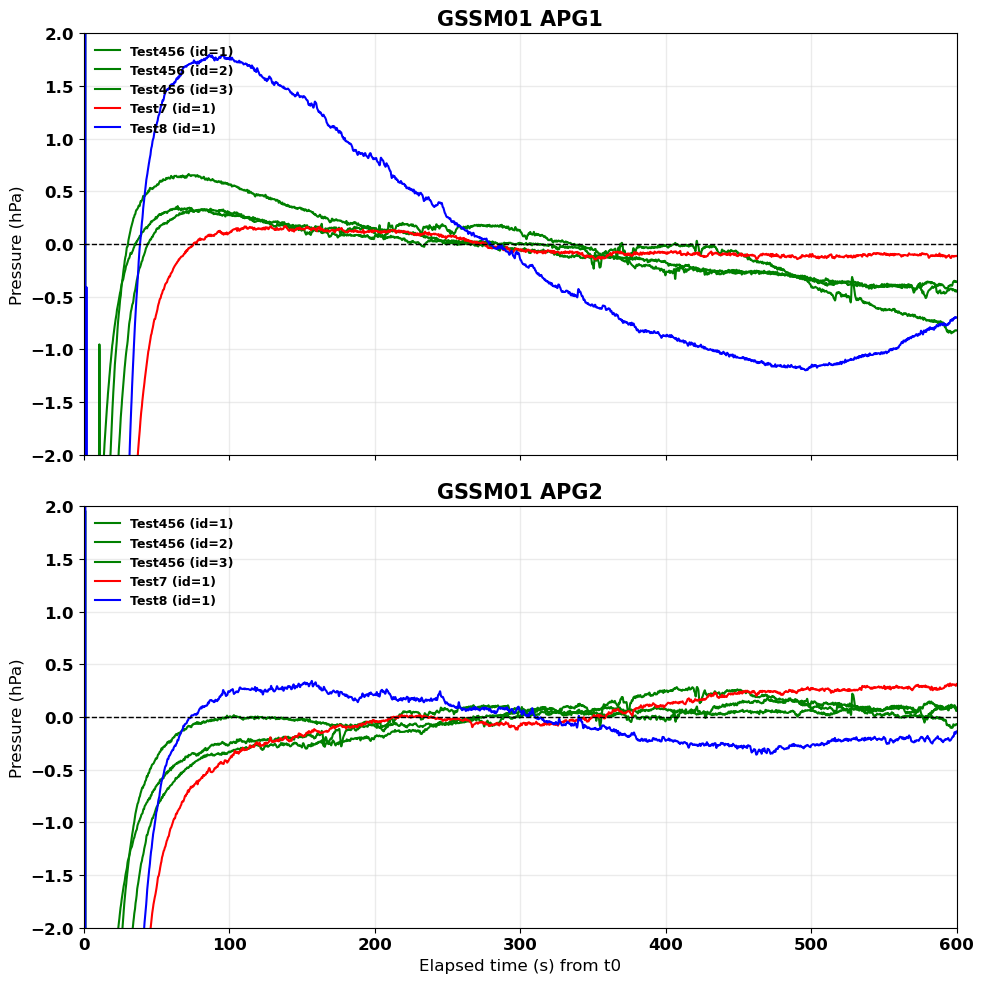

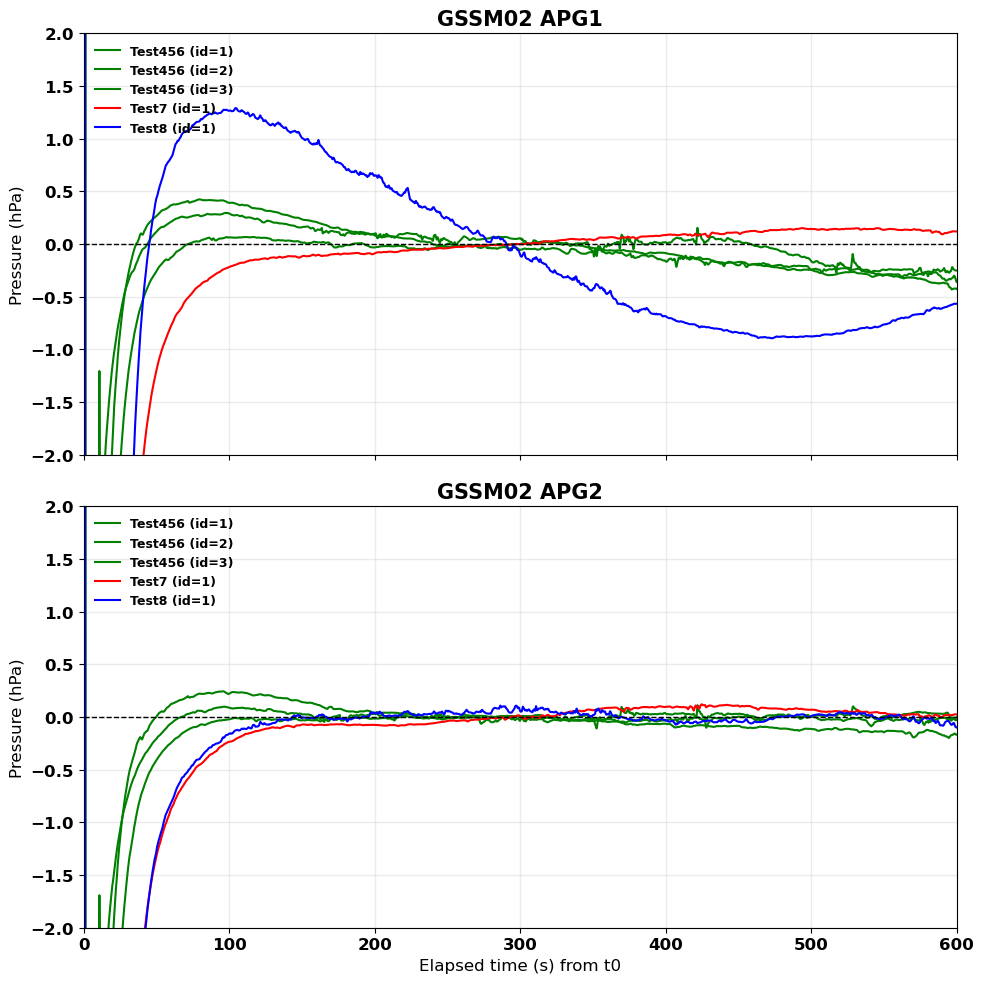

In [428]:
TARGET_TEST_NAMES = { "test456", "test7", "test8"}

# Which test_id to plot for each test (None → use all ids)
ID_FILTER = {
    "test123": {1, 2, 3},
    # "test456": {1, 2, 3},
    # "test7":   {1},
    # "test8":   {1},
}

# Axis labels and legend config
AX_LABELS = {
    "y_pressure": "Pressure (hPa)",
    "x_elapsed":  "Elapsed time (s) from t0",
}

LEGEND_CFG = {
    "loc": "upper left",
    "fontsize": 9,
    "frameon": False,
}

# Plot titles per sensor id
TITLE_CFG = {
    "01": {"apg1": "GSSM01 APG1", "apg2": "GSSM01 APG2"},
    "02": {"apg1": "GSSM02 APG1", "apg2": "GSSM02 APG2"},
}

# Label template
LABEL_TEMPLATE = "{base} (id={tid})"

plt.rcParams.update({
    "font.size": 12,
    "font.weight": "bold",
    "axes.grid": True,
    "grid.color": "0.85",
    "grid.linestyle": "-",
    "grid.linewidth": 1,
    "figure.facecolor": "white",
})

for sid in SENSOR_IDS:
    if sid not in COEFFS:
        print(f"[WARN] COEFFS does not contain GSSM{sid}, skip visualization")
        continue

    tc1, tc2 = COEFFS[sid]
    files = interval_files[sid]
    if not files:
        print(f"[WARN] GSSM{sid}: no interval CSV files")
        continue

    data_all = []

    for path in files:
        df = pd.read_csv(path)
        df["elapsed_s"] = pd.to_numeric(df["elapsed_s"], errors="coerce")
        df = df.dropna(subset=["elapsed_s"])

        # support both ..._test123.csv and ..._test123_sel.csv
        m = re.search(r"_calibration_intervals_(.+?)(?:_sel)?\.csv$", path.name)
        test_name = m.group(1) if m else path.stem

        if TARGET_TEST_NAMES and (test_name not in TARGET_TEST_NAMES):
            continue

        allowed_ids = ID_FILTER.get(test_name)  # set or None

        for tid in sorted(df["test_id"].unique()):
            if allowed_ids is not None and tid not in allowed_ids:
                continue

            sub = df[df["test_id"] == tid].copy()
            if sub.empty:
                continue

            sub = sub[(sub["elapsed_s"] >= -20) & (sub["elapsed_s"] <= 3700)]

            # psi → hPa
            sub["Sensor5_hPa"] = sub["Sensor5"] * PSI_TO_HPA
            sub["Sensor7_hPa"] = sub["Sensor7"] * PSI_TO_HPA
            sub["baro_hPa"]    = sub["baro_P"] * PSI_TO_HPA

            # Barometric and thermal correction
            sub["corr_S1_psi"] = (sub["Sensor5"] - sub["baro_P"]) + tc1 * sub["Sensor6"]
            sub["corr_S2_psi"] = (sub["Sensor7"] - sub["baro_P"]) + tc2 * sub["Sensor8"]
            sub["corr_S1_hPa"] = sub["corr_S1_psi"] * PSI_TO_HPA
            sub["corr_S2_hPa"] = sub["corr_S2_psi"] * PSI_TO_HPA

            # Baseline correction (mean in 100–500 s → 0)
            for key in ["Sensor5_hPa", "Sensor7_hPa", "corr_S1_hPa", "corr_S2_hPa", "baro_hPa"]:
                sub[key] = zero_mean_by_window(sub[key], sub["elapsed_s"])

            # Low-pass filter
            dt = np.median(np.diff(sub["elapsed_s"]))
            fs = 1.0 / dt if dt > 0 else 1.0
            cutoff = 1.0  # Hz
            for key in ["corr_S1_hPa", "corr_S2_hPa"]:
                sub[key + "_filt"] = butter_lowpass_filter(sub[key], cutoff, fs)

            color_cfg = PLOT_COLORS.get(test_name, {"pressure": None, "temp": None})
            base_label = PLOT_LABELS.get(test_name, test_name)
            label = LABEL_TEMPLATE.format(base=base_label, tid=tid)

            data_all.append((test_name, label, color_cfg, sub))

    if not data_all:
        print(f"[WARN] GSSM{sid}: no data for visualization")
        continue

    fig, axes = plt.subplots(2, 1, figsize=(10, 10), sharex=True)

    # APG1 (Sensor5)
    ax1 = axes[0]
    for test_name, label, color_cfg, sub in data_all:
        t  = sub["elapsed_s"]
        pc = color_cfg["pressure"] or "C0"
        ax1.plot(t, sub["corr_S1_hPa_filt"], "-", lw=1.5, color=pc, label=label)

    ax1.set_ylabel(AX_LABELS["y_pressure"])
    ax1.set_xlim(0, 3700)
    ax1.set_ylim(-2, 2)
    ax1.axhline(0, color="k", linestyle="--", linewidth=1)
    ax1.grid(True, linestyle="-", alpha=0.5)
    ax1.set_title(TITLE_CFG.get(sid, {}).get("apg1", f"GSSM{sid} APG1"),
                  fontsize=15, fontweight="bold")
    handles, labels = ax1.get_legend_handles_labels()
    ax1.legend(handles, labels, **LEGEND_CFG)

    # APG2 (Sensor7)
    ax2 = axes[1]
    for test_name, label, color_cfg, sub in data_all:
        t  = sub["elapsed_s"]
        pc = color_cfg["pressure"] or "C0"
        ax2.plot(t, sub["corr_S2_hPa_filt"], "-", lw=1.5, color=pc, label=label)

    ax2.set_ylabel(AX_LABELS["y_pressure"])
    ax2.set_xlabel(AX_LABELS["x_elapsed"])
    ax2.set_xlim(0, 600)
    ax2.set_ylim(-2, 2)
    ax2.axhline(0, color="k", linestyle="--", linewidth=1)
    ax2.grid(True, linestyle="-", alpha=0.5)
    ax2.set_title(TITLE_CFG.get(sid, {}).get("apg2", f"GSSM{sid} APG2"),
                  fontsize=15, fontweight="bold")
    handles, labels = ax2.get_legend_handles_labels()
    ax2.legend(handles, labels, **LEGEND_CFG)

    plt.tight_layout()
    plt.show()
